### Spark Session creation & Importing required packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession.builder.appName("Retail_Store_analysis").getOrCreate()

In [2]:
# Import packages

import os
import pandas as pd
import numpy as np

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
# Visualization parameters
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

### Read the reatail store data file 

In [5]:
data  = spark.read.csv("missing_data.csv", header=True)

In [6]:
data.show()

+---------+------------+----------+-----------------+--------------------+-----------+----------------+------------+-------------+---------------+-----------+------+---------------------+-----------------------------+----------------------+-----------------+
| order_id| customer_id|      date|nearest_warehouse|       shopping_cart|order_price|delivery_charges|customer_lat|customer_long|coupon_discount|order_total|season|is_expedited_delivery|distance_to_nearest_warehouse|latest_customer_review|is_happy_customer|
+---------+------------+----------+-----------------+--------------------+-----------+----------------+------------+-------------+---------------+-----------+------+---------------------+-----------------------------+----------------------+-----------------+
|ORD382112|ID0289597187|2019-03-06|         Thompson|[('pearTV', 1), (...|     7170.0|           61.72| -37.8117825|  144.9519722|             15|    6156.22|Autumn|                 True|                       0.4425|  to m

In [7]:
data.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- nearest_warehouse: string (nullable = true)
 |-- shopping_cart: string (nullable = true)
 |-- order_price: string (nullable = true)
 |-- delivery_charges: string (nullable = true)
 |-- customer_lat: string (nullable = true)
 |-- customer_long: string (nullable = true)
 |-- coupon_discount: string (nullable = true)
 |-- order_total: string (nullable = true)
 |-- season: string (nullable = true)
 |-- is_expedited_delivery: string (nullable = true)
 |-- distance_to_nearest_warehouse: string (nullable = true)
 |-- latest_customer_review: string (nullable = true)
 |-- is_happy_customer: string (nullable = true)



### Data Analysis & Visualization

In [8]:
# Average order total per order
data=data.withColumn('order_total',data['order_total'].cast("float").alias('order_total'))
data.select(['order_total', 'order_id']).select((F.sum('order_total') / F.countDistinct('order_id')).\
                                                alias('avg_order_total_per_order')).show()

+-------------------------+
|avg_order_total_per_order|
+-------------------------+
|       11701.044192626952|
+-------------------------+



In [9]:
# Average order total per day

avg_order_total_per_day = data.select(['date', 'order_total', 'order_id']) \
     .groupBy('date') \
     .agg((F.sum('order_total') / F.countDistinct('order_id')).alias('avg_order_total_per_day')) \
     .orderBy('date')

avg_order_total_per_day.cache()

DataFrame[date: string, avg_order_total_per_day: double]

In [10]:
avg_order_total_per_day.show()

+----------+-----------------------+
|      date|avg_order_total_per_day|
+----------+-----------------------+
|2019-01-01|      9282.360107421875|
|2019-01-02|        20632.599609375|
|2019-01-04|       13510.8701171875|
|2019-01-05|       4248.39013671875|
|2019-01-07|       14530.2197265625|
|2019-01-08|      9191.515075683594|
|2019-01-10|         14748.08984375|
|2019-01-11|       5831.81982421875|
|2019-01-12|     13123.159830729166|
|2019-01-13|       11255.3603515625|
|2019-01-14|         11087.51953125|
|2019-01-16|      14602.14501953125|
|2019-01-17|       17408.0146484375|
|2019-01-19|         8567.509765625|
|2019-01-20|      7856.479736328125|
|2019-01-21|      7034.102600097656|
|2019-01-23|       10471.3095703125|
|2019-01-26|      5307.525146484375|
|2019-01-28|      8649.416666666666|
|2019-01-29|        24534.599609375|
+----------+-----------------------+
only showing top 20 rows



In [11]:
# Average order total per month
avg_order_total_per_month = (avg_order_total_per_day
                     .select(F.month('date').alias('month'), 'avg_order_total_per_day')
                     .groupBy('month')
                     .agg(F.avg('avg_order_total_per_day').alias('avg_order_total_per_month'))
                     .orderBy('month'))

avg_order_total_per_month.cache()

DataFrame[month: int, avg_order_total_per_month: double]

In [12]:
avg_order_total_per_month.show()

+-----+-------------------------+
|month|avg_order_total_per_month|
+-----+-------------------------+
|    1|       12035.911105685764|
|    2|       11715.863966045958|
|    3|       12736.377777630349|
|    4|       12880.874691233916|
|    5|        13819.85400390625|
|    6|       12287.348791503906|
|    7|       10343.422439778646|
|    8|        12614.14808078342|
|    9|       12458.227652768735|
|   10|       11584.775953020368|
|   11|       10636.051413167319|
|   12|       12647.330088071469|
+-----+-------------------------+



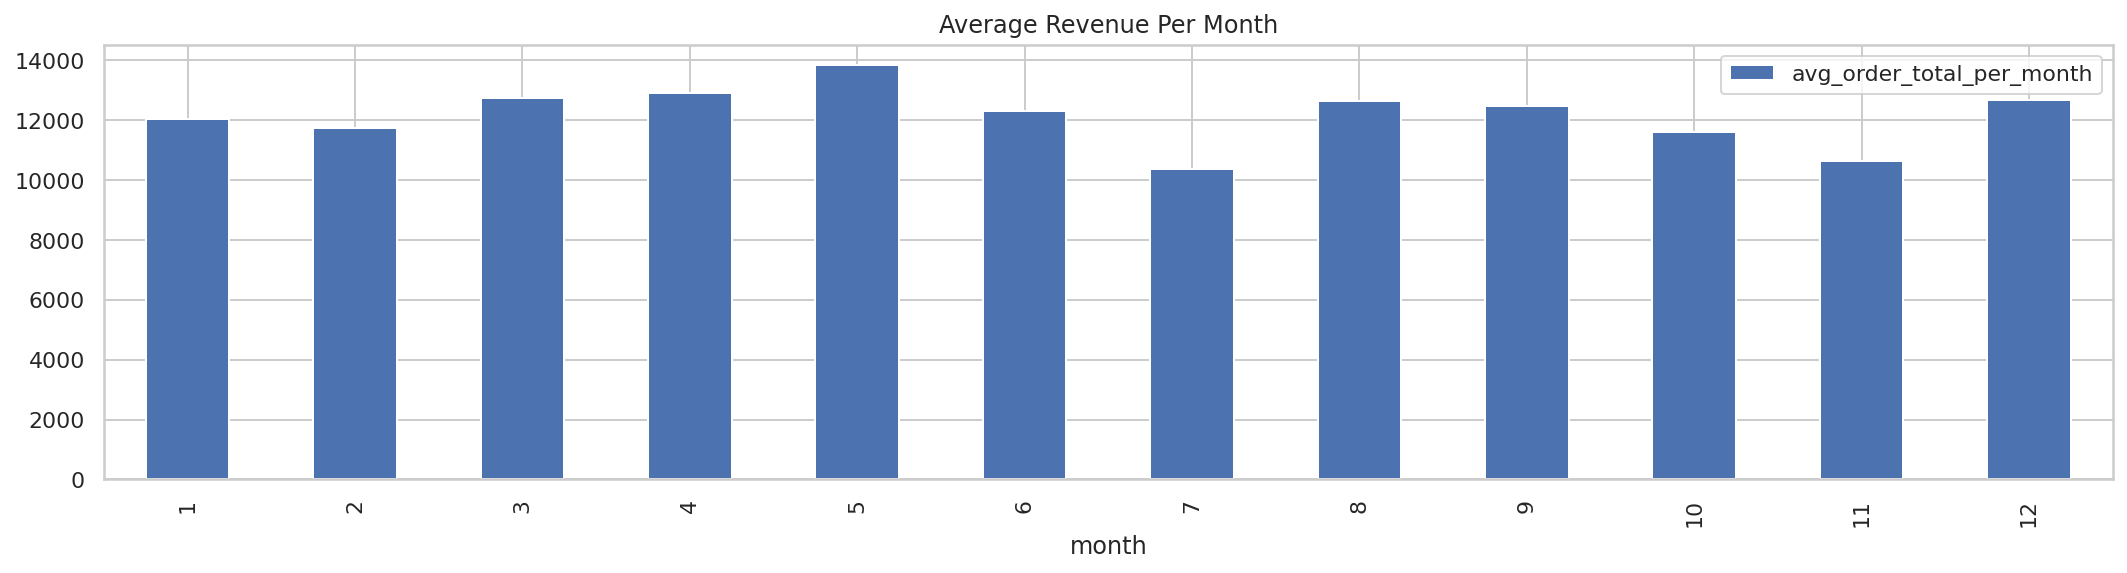

In [13]:
avg_order_total_per_month.toPandas().plot.bar(x='month', title='Average Revenue Per Month');

In [14]:
# unpersist the cached data
avg_order_total_per_month.unpersist()
avg_order_total_per_day.unpersist()

DataFrame[month: int, avg_order_total_per_month: double]

DataFrame[date: string, avg_order_total_per_day: double]

In [15]:
# Total order total per month per year

tot_order_total_per_month_per_year = data.select([F.year('date').alias('order_year'), F.month('date') \
     .alias('order_month'), 'order_total']).groupBy(['order_year', 'order_month']) \
     .agg(F.sum('order_total').alias('tot_revenue')) \
     .orderBy(['order_year', 'order_month'])

tot_order_total_per_month_per_year.cache()

DataFrame[order_year: int, order_month: int, tot_revenue: double]

In [16]:
tot_order_total_per_month_per_year.show()

+----------+-----------+------------------+
|order_year|order_month|       tot_revenue|
+----------+-----------+------------------+
|      2019|          1|454705.78662109375|
|      2019|          2| 406944.5593261719|
|      2019|          3|464520.26068115234|
|      2019|          4|416252.78967285156|
|      2019|          5| 582203.0200195312|
|      2019|          6|408242.65673828125|
|      2019|          7| 396865.8308105469|
|      2019|          8| 591239.2232666016|
|      2019|          9| 480586.6580810547|
|      2019|         10|520837.65979003906|
|      2019|         11| 537841.6093139648|
|      2019|         12| 590282.0419921875|
+----------+-----------+------------------+



In [17]:
# Total revenue by nearest_warehouse

df = data.select('nearest_warehouse', F.year('date').alias('order_year'), 'order_total') \
      .groupBy(['nearest_warehouse', 'order_year']) \
      .agg(F.sum('order_total').alias('tot_revenue')) \
      .orderBy('tot_revenue') 
df.cache()

DataFrame[nearest_warehouse: string, order_year: int, tot_revenue: double]

In [18]:
df.show()

+-----------------+----------+------------------+
|nearest_warehouse|order_year|       tot_revenue|
+-----------------+----------+------------------+
|             null|      2019| 137753.7099609375|
|           Bakers|      2019|1175942.3063964844|
|        Nickolson|      2019| 2265672.797607422|
|         Thompson|      2019| 2271153.282348633|
+-----------------+----------+------------------+



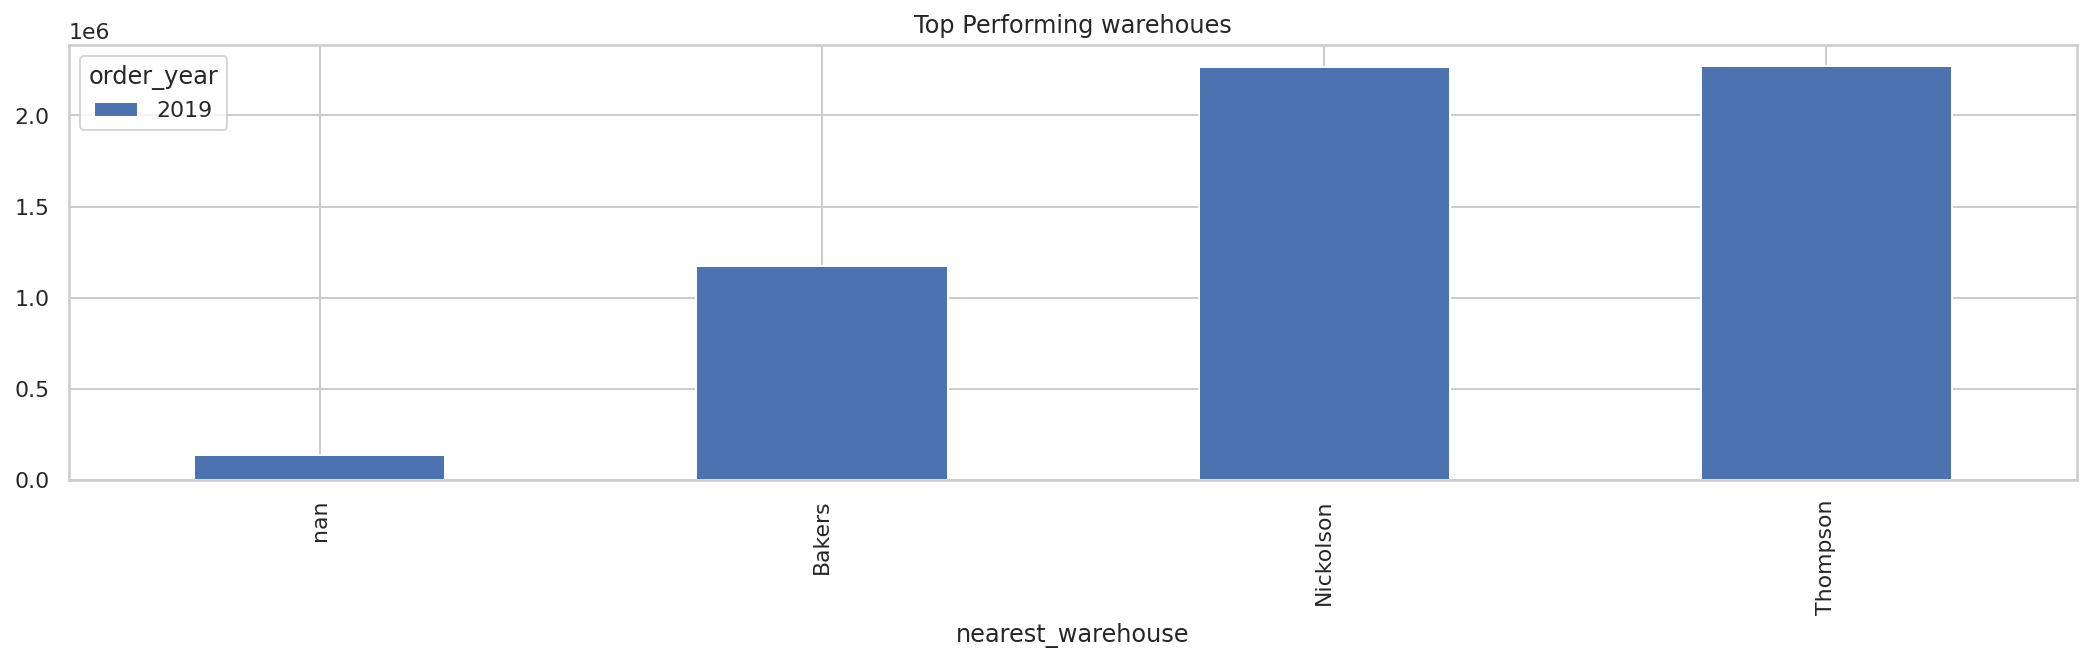

In [19]:
pdf = df.toPandas()

pdf = pdf.pivot(index='nearest_warehouse', columns='order_year', values='tot_revenue')
pdf.plot.bar(stacked=True, title='Top Performing warehoues');

In [20]:
# Total revenue by season

df1 = data.select('season', F.year('date').alias('order_year'), 'order_total') \
      .groupBy(['season', 'order_year']) \
      .agg(F.sum('order_total').alias('tot_revenue')) \
      .orderBy('tot_revenue') 
df1.cache()

DataFrame[season: string, order_year: int, tot_revenue: double]

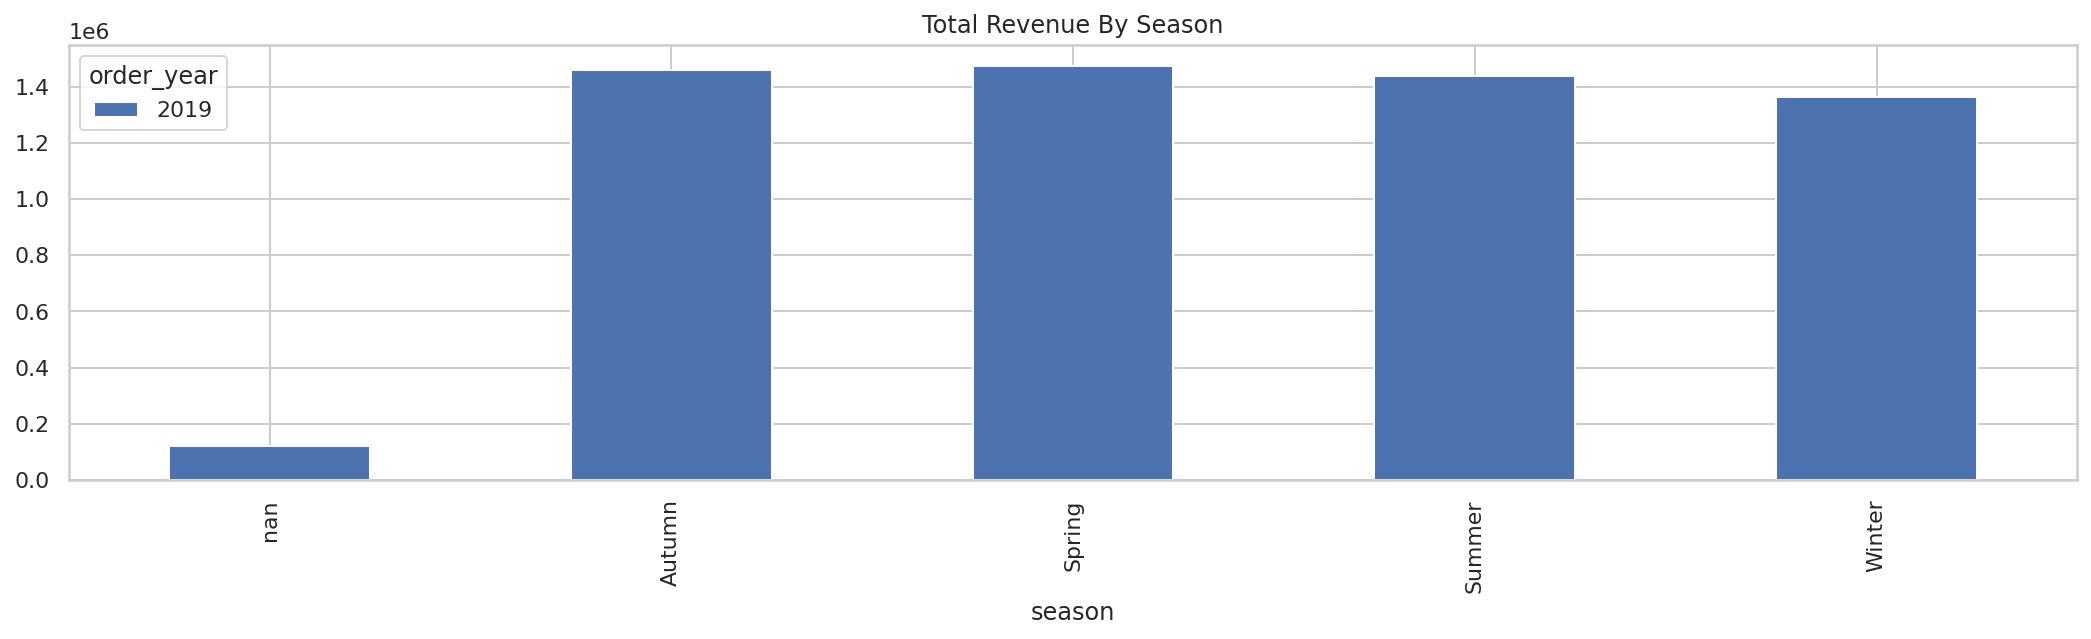

In [21]:
pdf1 = df1.toPandas()

pdf1 = pdf1.pivot(index='season', columns='order_year', values='tot_revenue')
pdf1.plot.bar(stacked=True, title='Total Revenue By Season');

In [22]:
# Is customer happy??

df2 = data.groupBy('is_happy_customer').count().withColumnRenamed('count', 'total')
df2.cache()

DataFrame[is_happy_customer: string, total: bigint]

In [23]:
df2.show()

+--------------------+-----+
|   is_happy_customer|total|
+--------------------+-----+
| there does not s...|    1|
| language etc.) r...|    1|
|               False|  111|
|                null|   10|
| but getting the ...|    1|
| great cameras (f...|    1|
|                True|  375|
+--------------------+-----+



In [24]:
# Transform the data as to have only "true" and "false" values

from pyspark.sql.functions import *

data = data.withColumn('is_happy_customer', when(df2['is_happy_customer'] != "True","False").otherwise('True'))\
.drop(df2['is_happy_customer'])

In [25]:
df3 = data.groupBy('is_happy_customer').count().withColumnRenamed('count', 'total')
df3.cache()

DataFrame[is_happy_customer: string, total: bigint]

In [26]:
pdf2 = df3.toPandas()
df3.show()

+-----------------+-----+
|is_happy_customer|total|
+-----------------+-----+
|            False|  115|
|             True|  385|
+-----------------+-----+



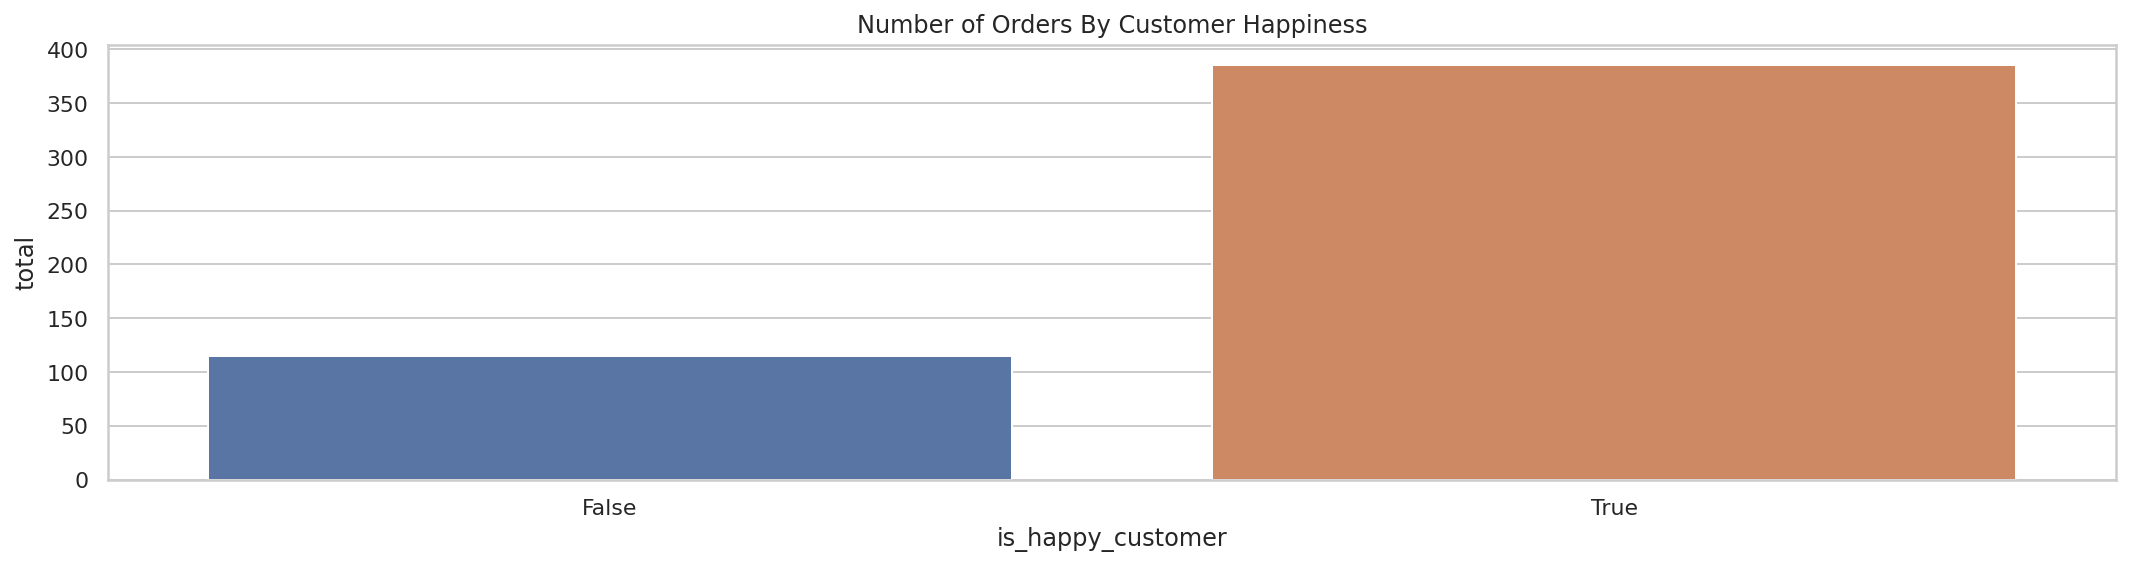

In [27]:
g = sns.barplot(x='is_happy_customer', y='total', data=pdf2)
g.set_title('Number of Orders By Customer Happiness');

### Data transformation for modelling 

In [28]:
imputed_df = data.toPandas()
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              490 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    490 non-null    object 
 6   delivery_charges               500 non-null    object 
 7   customer_lat                   490 non-null    object 
 8   customer_long                  490 non-null    object 
 9   coupon_discount                500 non-null    object 
 10  order_total                    490 non-null    float32
 11  season                         490 non-null    object 
 12  is_expedited_delivery          500 non-null    obj

In [29]:
# Data type casting
imputed_df['order_price']  = imputed_df['order_price'].astype('float64')
imputed_df['delivery_charges']  = imputed_df['delivery_charges'].astype('float64')
imputed_df['customer_lat']  = imputed_df['customer_lat'].astype('float64')
imputed_df['customer_long']  = imputed_df['customer_long'].astype('float64')
imputed_df['coupon_discount']  = imputed_df['coupon_discount'].astype('float64')
imputed_df['distance_to_nearest_warehouse']  = imputed_df['distance_to_nearest_warehouse'].astype('float64')

In [30]:
# Replace NA's with zero
imputed_df.fillna(0, inplace=True)

In [31]:
# Drop unwanted columns
imputed_df.drop(['order_id', 'customer_id', 'date', 'shopping_cart'], axis = 1,inplace=True)

In [32]:
# Transform categorical columns
transform_dict = {}
for col in imputed_df.columns:
    cats = pd.Categorical(imputed_df[col]).categories
    d = {}
    for i, cat in enumerate(cats):
        d[cat] = i
    transform_dict[col] = d

In [33]:
imputed_df.replace(transform_dict, inplace=True)

In [34]:
df_converted = spark.createDataFrame(imputed_df)
df_converted.show(5, truncate=False)

+-----------------+-----------+----------------+------------+-------------+---------------+-----------+------+---------------------+-----------------------------+----------------------+-----------------+
|nearest_warehouse|order_price|delivery_charges|customer_lat|customer_long|coupon_discount|order_total|season|is_expedited_delivery|distance_to_nearest_warehouse|latest_customer_review|is_happy_customer|
+-----------------+-----------+----------------+------------+-------------+---------------+-----------+------+---------------------+-----------------------------+----------------------+-----------------+
|3                |86.0       |49.0            |276.0       |123.0        |3.0            |117.0      |1     |1                    |61.0                         |444                   |0                |
|3                |209.0      |88.0            |345.0       |60.0         |2.0            |280.0      |1     |0                    |99.0                         |403                   

### Classification modelling 

In [35]:
# Split the data into training and testing data sets
X = df_converted.toPandas().filter(items=['nearest_warehouse', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review'])
Y = df_converted.toPandas().filter(items=['is_happy_customer'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [36]:
# Resample the imbalanced data using SMOTE
sm = SMOTE(random_state=12, sampling_strategy=0.75)
x_train_res, y_train_res = sm.fit_resample(X_train, Y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Resampled dataset shape Counter({'is_happy_customer': 1})


In [37]:
y_train_res.value_counts()

is_happy_customer
1                    282
0                    211
dtype: int64

In [38]:
dataframe_1 = pd.DataFrame(x_train_res,columns=['nearest_warehouse', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['is_happy_customer'])
result = dataframe_1.combine_first(dataframe_2)
imputeDF_1 = spark.createDataFrame(result)

In [39]:
# Apply binarizer to create lable column
binarizer = Binarizer(threshold=0.0, inputCol="is_happy_customer", outputCol="label")
binarizedDF = binarizer.transform(imputeDF_1)
binarizedDF = binarizedDF.drop('is_happy_customer')

In [40]:
# Apply assembler on the feature columns
featureColumns = ['nearest_warehouse', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review']
assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")
assembled = assembler.transform(binarizedDF)
print(assembled)

DataFrame[coupon_discount: double, customer_lat: double, customer_long: double, delivery_charges: double, distance_to_nearest_warehouse: double, is_expedited_delivery: bigint, latest_customer_review: bigint, nearest_warehouse: bigint, order_price: double, order_total: double, season: bigint, label: double, features: vector]


In [41]:
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed=0)
print("Distribution of Ones and Zeros in training data is: ", trainingData.groupBy("label").count().take(3))

Distribution of Ones and Zeros in training data is:  [Row(label=0.0, count=153), Row(label=1.0, count=201)]


In [42]:
# Train decision tree model on the training data
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, minInstancesPerNode=10, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

In [43]:
# Predict using the trained model on the testing data
predictions = model.transform(testData)

In [44]:
# Model performance evaluation
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

Test Data Aread under ROC score is :  0.8519582801191995


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic Graph')

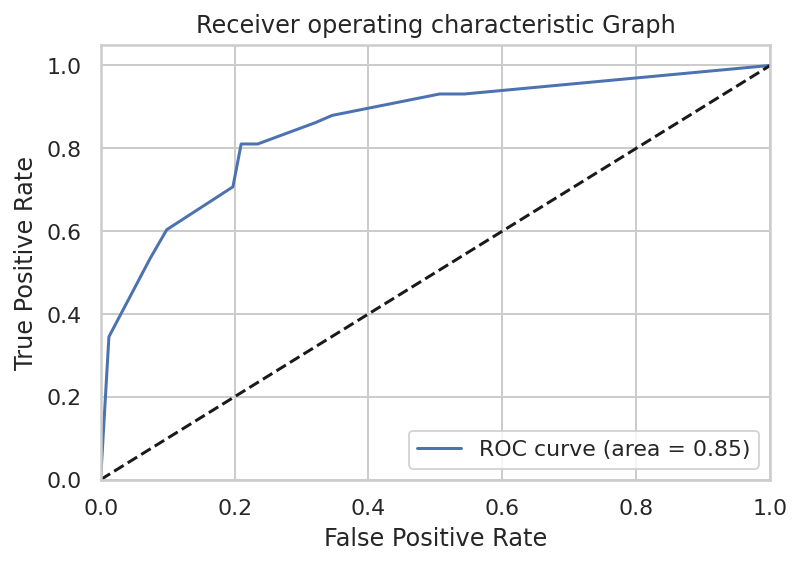

In [45]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()